Nice color picker to generate color schemes: https://coolors.co

In [73]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display,SVG
from matplotlib.ticker import MaxNLocator
from scipy.stats import entropy
import glob
import MESS
import numpy as np
import pandas as pd
import seaborn as sns
import collections

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

analysis_dir = "/home/juliette/Documents/internship_m1_MESS/MESS/fig2/"

sp_dict = {"no":0, "lo":0.0005, "hi":0.005}
models = ["neutral", "competition", "filtering", "pairwise_competition"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
res = pd.read_csv(analysis_dir+'OUT_modif.txt', sep="\t", header=0)

display(res)


,seed,S_m,J_m,speciation_rate,death_proportion,trait_rate_meta,ecological_strength,intrasp_competition_a,intrasp_competition_b,intersp_competition_a,intersp_competition_b,mutualism_proportion,generations,community_assembly_model,speciation_model,mutation_rate,alpha,sequence_length,J,m,speciation_prob,generation,_lambda,migrate_calculated,extrate_calculated,trait_rate_local,filtering_optimum,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,trait_h1,trait_h2,trait_h3,trait_h4,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,abundance_dxy_cor,abundance_pi_cor,abundance_trait_cor,dxy_pi_cor,dxy_trait_cor,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,1.280330e+09,250.0,500000.0,2.0,0.7,2.0,0.1,-1.0,-1.0,-1.0,-1.0,0.0,0.75,neutral,point_mutation,0.0,2000.0,570.0,1000.0,0.005,0.0,39.0,0.774,0.00544,0.00308,0.58824,-1.63324,12.0,1.46573,1.15475,1.11499,1.10160,1.00000,1.00000,1.00000,1.00000,0.00003,0.00010,3.01511,7.09091,0.00000,0.00000,0.00067,0.00121,2.31213,4.38627,0.00000,0.00079,0.0,11.22024,9.33389,8.69242,8.28246,0.55479,3.30552,0.25543,-0.27182,0.14315,2.48559,0.33576,3.42167,-0.40280,0.61436,0.47990,4.14894,-0.21903,0.11615,-0.65823,0.88617,0.33675,1.66335,0.54872,0.48990,-0.04992,0.53568,-0.28073,-0.39304,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4.772878e+08,250.0,500000.0,2.0,0.7,2.0,0.1,-1.0,-1.0,-1.0,-1.0,0.0,0.75,neutral,point_mutation,0.0,2000.0,570.0,1000.0,0.005,0.0,109.0,0.820,0.00558,0.00288,0.58824,12.01834,20.0,2.95660,1.72138,1.52049,1.45198,9.09334,7.72340,6.86742,6.33008,0.00039,0.00049,1.35373,1.01771,0.00035,0.00044,0.00154,0.00163,0.63204,-1.14916,0.00096,0.00272,0.0,7.90799,5.95957,5.54776,5.37697,-1.09418,3.40761,0.18989,-0.89732,-1.49996,4.56881,-0.14450,3.33079,-0.07404,-0.50849,0.14112,4.60940,0.94969,-0.07682,-0.26392,0.38883,1.64108,0.04060,0.68260,0.58555,-0.37056,0.89681,-0.04043,0.11764,9.0,0.0,6.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0
2,4.970439e+07,250.0,500000.0,2.0,0.7,2.0,0.1,-1.0,-1.0,-1.0,-1.0,0.0,0.75,filtering,point_mutation,0.0,2000.0,570.0,1000.0,0.005,0.0,30.0,0.838,0.00573,0.00267,0.58824,-3.48130,14.0,3.35770,2.84636,2.71379,2.64437,9.63594,8.59227,7.80879,7.21625,0.00060,0.00048,0.65332,0.08268,0.00053,0.00058,0.00207,0.00229,1.77159,2.52575,0.00123,0.00180,0.0,4.97803,3.91616,3.65594,3.46054,-3.68578,1.61887,-0.36698,-0.80314,-3.33504,2.29269,-3.29805,2.45127,-0.52887,-0.12879,-2.91528,3.46880,0.38773,0.83240,-0.16189,0.67435,0.41976,1.17611,0.68490,0.24626,-0.45284,0.31987,-0.02867,0.08981,3.0,0.0,4.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0
3,1.854077e+09,250.0,500000.0,2.0,0.7,2.0,0.1,-1.0,-1.0,-1.0,-1.0,0.0,0.75,filtering,point_mutation,0.0,2000.0,570.0,1000.0,0.005,0.0,82.0,0.783,0.00493,0.00263,0.58824,-5.67370,19.0,4.27350,3.21455,2.91628,2.74819,2.95707,2.91705,2.88038,2.84727,0.00016,0.00039,2.00615,2.23666,0.00000,0.00000,0.00100,0.00115,0.58104,-1.17656,0.00000,0.00175,0.0,5.28640,3.93215,3.64470,3.51911,-4.48460,4.12232,0.98682,-0.40863,-5.83165,4.54547,-5.32246,3.92609,0.55344,-0.17157,-5.86138,5.09569,-0.83786,-0.19623,-0.43338,0.23706,-0.02973,0.55023,-0.07057,0.14888,0.09279,0.59103,0.19580,0.34247,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1.054081e+09,250.0,500000.0,2.0,0.7,2.0,0.1,-1.0,-1.0,-1.0,-1.0,0.0,0.75,neutral,point_mutation,0.0,2000.0,570.0,1000.0,0.005,0.0,319.0,0.753,0.00484,0.00251,0.58824,1.19895,16.0,7.35810,5.99097,5.39673,5.05645,6.75617,5.33742,4.50016,4.02136,0.00129,0.00182,2.00029,3.86767,0.00064,0.00200,0.00451,0.00357,0.33412,-1.00485,0.00404,0.00553,0.

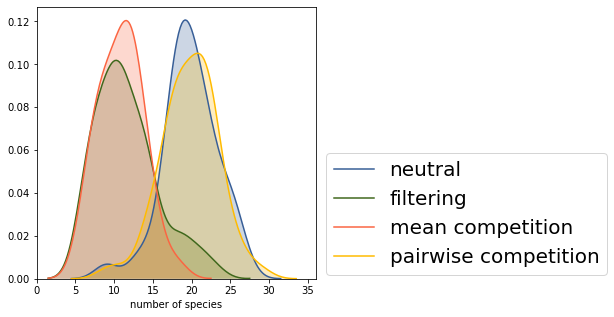

In [75]:
%matplotlib inline
def plot_abundance(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    for m in models:
        simdir = analysis_dir + "{}_MESS/".format(m)

        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, speciation_prob))

        log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]

        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, np.log(means), c=MESS.plotting.model_colors[m])
        ax.plot(xs, np.log(means + stds), c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), color=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                        color=MESS.plotting.model_colors[m], alpha=0.25)

def plot_pi(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    for m in models:
        simdir = analysis_dir + "{}_MESS/".format(m)

        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, speciation_prob))

        log_dat = [pd.read_csv(x)["pi_local"].sort_values(ascending=False).values for x in logs]

        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, color=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds,
                        color=MESS.plotting.model_colors[m], alpha=0.25)


def plot_richness(ax='', figsize=(5, 5), simfile=analysis_dir + "OUT_modif.txt",\
                     speciation_prob="no", xlim=(0,36), legend=False):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    
    labels, sim_df = MESS.plotting._filter_sims(simfile,\
                            feature_set=["S", "speciation_prob"],\
                            normalize_hills=False)

    mask = (sim_df["S"] > 5) & (sim_df["speciation_prob"] == sp_dict[speciation_prob])
    sim_df = sim_df[mask]
    labels = labels[mask]
    
    neut_df = sim_df[labels.values == "neutral"]
    filt_df = sim_df[labels.values == "filtering"]
    comp_df = sim_df[labels.values == "competition"]
    pw_df = sim_df[labels.values == "pairwise_competition"]

    bw_method=1.5
    ax = sns.kdeplot(neut_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["neutral"],
                    label="neutral", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(filt_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["filtering"],
                    label="filtering", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(comp_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["competition"],
                    label="mean competition", bw=bw_method,  legend=legend)
    
    ax = sns.kdeplot(pw_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["pairwise_competition"],
                    label="pairwise competition", bw=bw_method,  legend=legend)
    ax.set_xlim(xlim)

    ## If you have a legend, increase the font size
    try:
#        plt.legend(fontsize='20', loc='upper left')
        plt.setp(ax.get_legend().get_texts(), fontsize='15') 
    except:
        pass
#plot_abundance()
#plot_pi(speciation_prob="hi")
plot_richness(speciation_prob="lo", legend=False)
plt.legend(bbox_to_anchor=(1, 0.5), fontsize=20)
plt.xlabel("number of species")
plt.show()

In [76]:
def plot_traits(ax='', speciation_prob='hi', do_abs=True):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for m in models:
        simdir = analysis_dir + "{}_MESS".format(m)

        logs = glob.glob("{}/*{}-*/*megalog*".format(simdir, speciation_prob))
        log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
        log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
        abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
        #display(log_df)
        mask = (log_df.notna().sum() >= 3) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]
        mask = (abunds.notna().sum() >= 3) & (abunds.notna().sum() <= 21)
        abunds = abunds.loc[:, mask]

        col_means = log_df.mean()
        col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
        if do_abs:
            log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))
        else:
            log_df = pd.DataFrame(log_df.values - col_means_vec)
        
        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color=MESS.plotting.model_colors[m])

        ## Plot the average RAD
        #ax.plot(xs, np.log(abunds.apply(np.mean, axis=1)), c=MESS.plotting.model_colors[m])
        #ax.set_title(sp_prob, fontsize=20)

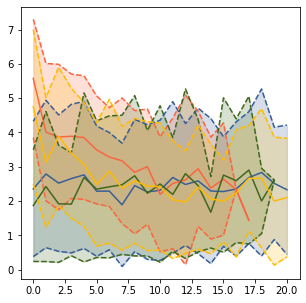

In [77]:
plot_traits(speciation_prob="no", do_abs=True)

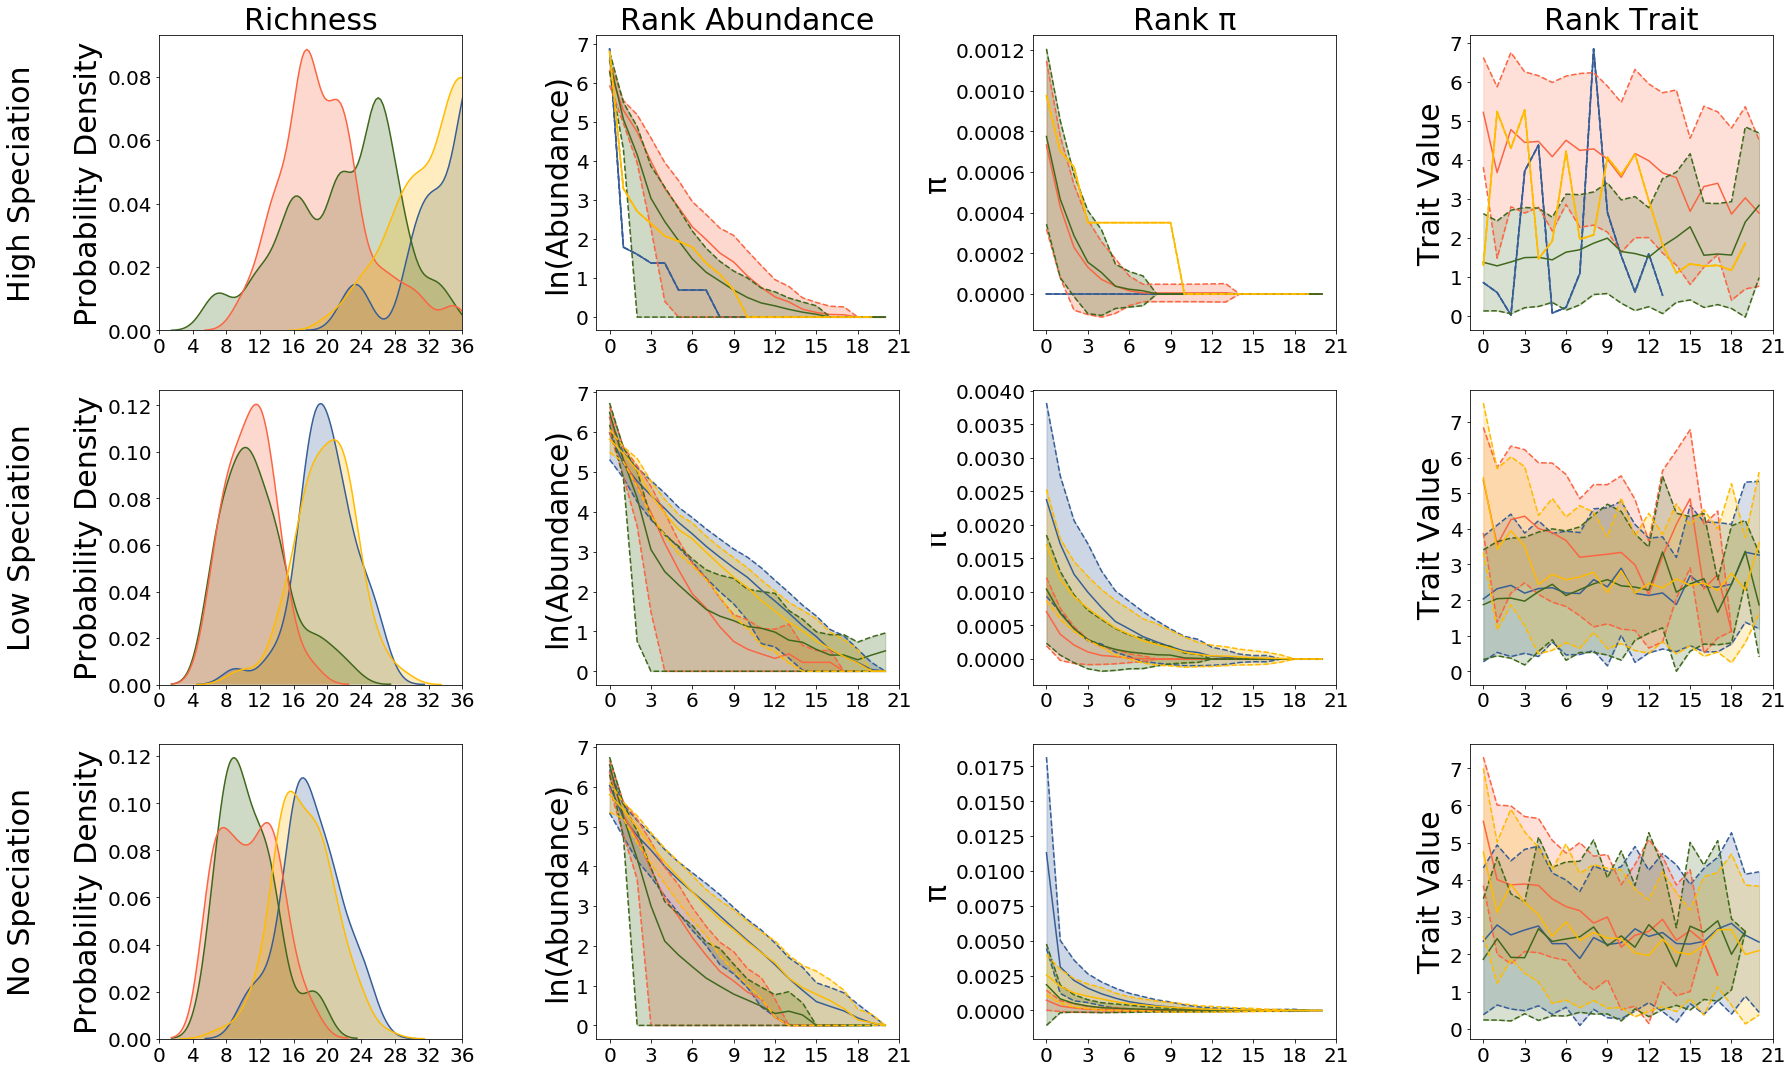

In [78]:
funcs = {"Richness":plot_richness,
         "Rank Abundance":plot_abundance,
         u"Rank π":plot_pi,
         "Rank Trait":plot_traits}
sp_title_dict = {"no":"No", "lo":"Low", "hi":"High"}

fig, axs = plt.subplots(3, 4, figsize=(25, 15))
for i, sp in enumerate(["hi", "lo", "no"]):
    for j, f in enumerate(["Richness", "Rank Abundance", u"Rank π", "Rank Trait"]):
        #if i == 0 and j == 0:
        #        funcs[f](ax=axs[i][j], speciation_prob=sp, legend=True)
        funcs[f](ax=axs[i][j], speciation_prob=sp)

        ## Labeling and cleaning up the plots
        if i % 4 == 0:
            axs[i][j].set_title(f, fontsize=30)
        if j % 4 == 0:
            axs[i][j].set_ylabel("{} Speciation\n\nProbability Density".format(sp_title_dict[sp]), fontsize=30)
        if j % 4 == 1:
            axs[i][j].set_ylabel("ln(Abundance)", fontsize=30)
        if j % 4 == 2:
            axs[i][j].set_ylabel(u"π", fontsize=30)
        if j % 4 == 3:
            axs[i][j].set_ylabel("Trait Value", fontsize=30)
        ## Cast xtick labelsto int
        axs[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
        
## Make axis ticklabels easier to read
axs = axs.flatten()
_ = [plt.setp(ax.get_xticklabels(), fontsize=20) for ax in axs.flatten()]
_ = [plt.setp(ax.get_yticklabels(), fontsize=20) for ax in axs.flatten()]

plt.tight_layout()

/home/juliette/Documents/internship_m1_MESS/MESS/fig2/neutral_MESS/neutral-no-506166938/island1-0.755-megalog.txt


,name,trait,abundance,Ne_local,Ne_meta,tdiv,growth_rate,migration_rate,segsites_tot,pi_tot,segsites_local,segsites_meta,pi_local,pi_meta,dxy,da,TajimaD
0,64.0,-6.699726,50,1.307402e+04,13790,86114,0,1.243498e-08,2,0.001690,1,1,0.000936,0.000351,0.002632,0.001988,1.390094
1,239.0,3.458502,228,3.964245e+04,29825,193648,0,6.122437e-09,9,0.006150,4,2,0.003431,0.000702,0.009825,0.007758,1.601740
2,67.0,-3.975738,40,9.010098e+03,4918,58541,0,1.895878e-09,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
3,110.0,2.608948,133,1.059110e+04,4449,61463,0,3.072380e-09,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
4,89.0,-5.370929,1,2.000000e+03,11048,4297,0,0.000000e+00,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
5,59.0,-4.026160,107,7.761146e+03,9668,43297,0,2.975886e-08,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
6,90.0,-4.293689,46,1.822671e+04,14965,67440,0,5.694717e-09,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000
7,114.0,-8.459969,246,1.190393e+06,52950,246000,0,3.858806e-10,27,0.010166,20,5,0.009786,0.004678,0.012807,0.005575,-0.831532
8,3.0,-4.289625,6,3.200000e+03,36824,5197,0,1.202617e-07,6,0.003047,0,6,0.000000,0.005068,0.003509,0.000975,0.000000
9,175.0,3.890356,2,2.000000e+03,25437,1192,0,0.000000e+00,1,0.000175,0,1,0.000000,0.000351,0.000175,0.000000,0.000000


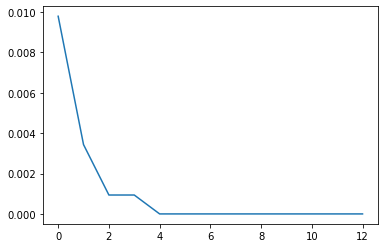

In [79]:
simdir = analysis_dir + "neutral_MESS"
logs = glob.glob("{}/*no-*/*megalog*".format(simdir))
print(logs[-1])
df = pd.read_csv(logs[-1])
pis = df["pi_local"]
xs = range(0, len(pis))
ys = sorted(pis, reverse=True)
plt.plot(xs, ys)
df

Removed invariant targets. Retained: ['S']
Nsims
  neutral	216
  filtering	197
  competition	120
 pairwise_competition	257


array([<matplotlib.axes._subplots.AxesSubplot object at 0x6fd832ca0890>],
      dtype=object)

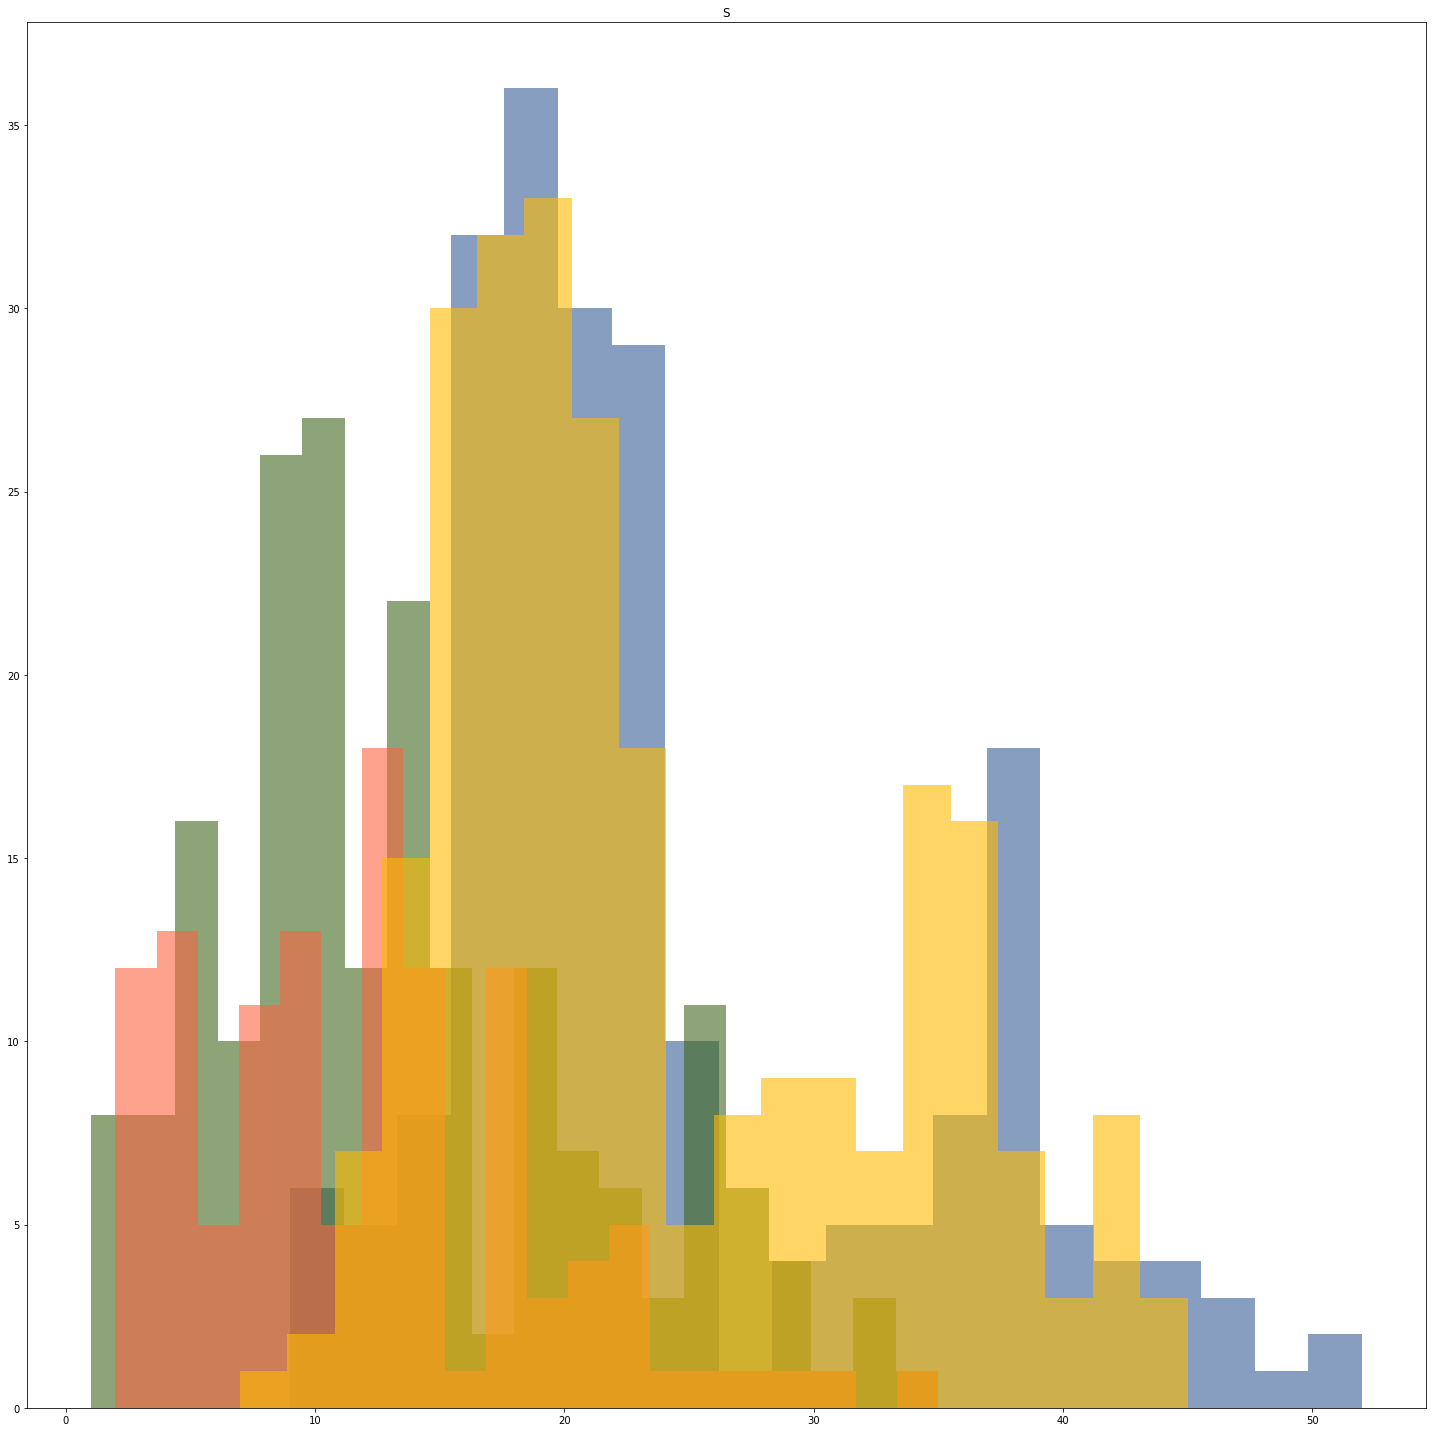

In [80]:
simfile = analysis_dir + "OUT_modif.txt"
#simfile = analysis_dir + "SIMOUT.txt"
sim_df = pd.read_csv(simfile, sep="\t", header=0)
MESS.plotting.plot_simulations_hist(simfile, verbose=True, normalize_hills=False,\
                                        feature_set=["S"])

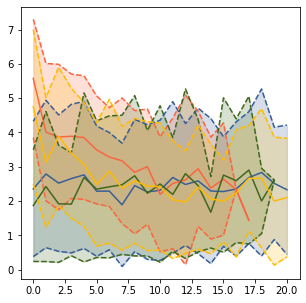

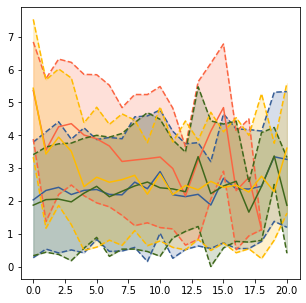

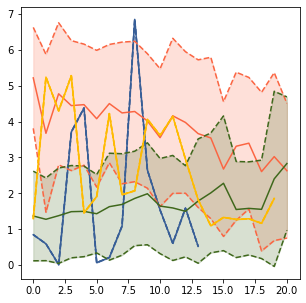

In [81]:

#plot_traits(speciation_prob="no", do_abs=False)
plot_traits(speciation_prob="no", do_abs=True)
plot_traits(speciation_prob="lo", do_abs=True)
plot_traits(speciation_prob="hi", do_abs=True)


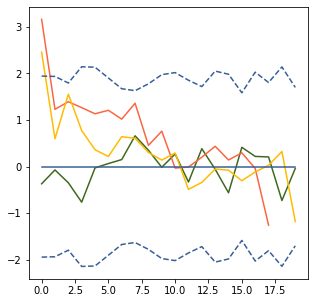

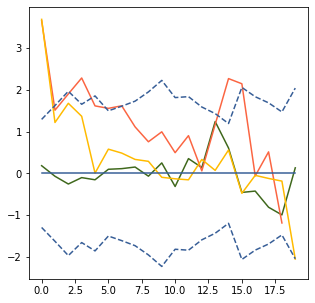

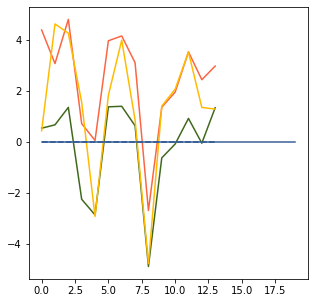

In [82]:
def plot_traits_residuals(ax='', sp_prob='hi'):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    mean_dict = {}
    std_dict = {}
    for m in models:
        simdir = analysis_dir + "{}_MESS".format(m)

        logs = glob.glob("{}/*{}-*/*megalog*".format(simdir, sp_prob))
        log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
        log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
        abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
        #display(log_df)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 20)
        log_df = log_df.loc[:, mask]
        mask = (abunds.notna().sum() >= 5) & (abunds.notna().sum() <= 20)
        abunds = abunds.loc[:, mask]

        col_means = log_df.mean()
        col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
        log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        mean_dict[m] = means[:24]
        std_dict[m] = stds[:24]

    for m in ["filtering", "competition","pairwise_competition"]:
        xs = range(0, len(mean_dict["neutral"]))
        means = (mean_dict[m] - mean_dict["neutral"])
        stds = (std_dict[m] - std_dict["neutral"])
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        #ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        #ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        #ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color=MESS.plotting.model_colors[m])
    xs = range(0, 20)
    ax.plot(xs, [0]*len(xs), color=MESS.plotting.model_colors["neutral"])
    ax.plot(xs, 0 + std_dict["neutral"][:20], c=MESS.plotting.model_colors["neutral"], ls='--')
    ax.plot(xs, 0 - std_dict["neutral"][:20], c=MESS.plotting.model_colors["neutral"], ls='--')

plot_traits_residuals(sp_prob="no")
plot_traits_residuals(sp_prob="lo")
plot_traits_residuals(sp_prob="hi")

In [83]:
mn = log_df[0].mean()
print(mn)
np.abs(log_df[0] - mn) * abunds.iloc[:, 0]

NameError: name 'log_df' is not defined

NameError: name 'df_dict' is not defined

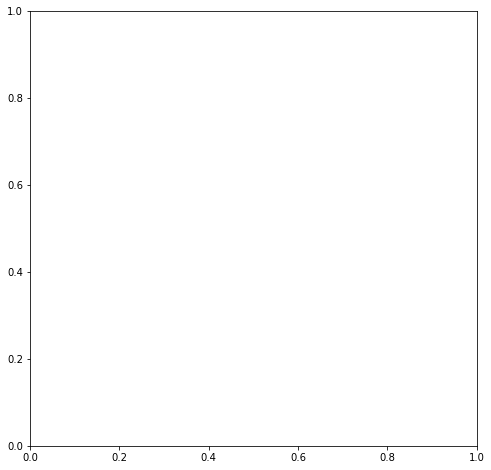

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
traits = True

for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)

    for sp in ["lo"]:
        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, sp))
        log_dat = [pd.read_csv(x)["trait"].sort_values(ascending=False).values for x in logs]
        
        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
        mask = log_df.notna().sum() == 17
        log_df = log_df.loc[:, mask]

        if traits:
            col_means = log_df.mean()
            col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
            log_df = pd.DataFrame(abs(log_df.values - col_means_vec))

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))

        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds, color=MESS.plotting.model_colors[m],alpha=0.5)


In [ ]:
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-3.5, 3.5, -6, 6],
           cmap='Blues')
cb = plt.colorbar()
cb.set_label("density")

## Trash below here

Figure 2 Dev

In [ ]:
df_dict = {}
fig, ax = plt.subplots(figsize=(5, 5))
traits = False

for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)

    for sp in ["no"]:
        logs = glob.glob("{}/*{}-*/*megalog.txt".format(simdir, sp))[:50]

        log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]
        
        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
        mask = log_df.notna().sum() == 15
        log_df = log_df.loc[:, mask]

        if traits:
            col_means = log_df.mean()
            col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
            log_df = pd.DataFrame(log_df.values - col_means_vec)

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        if True:
            ax.plot(xs, np.log(means), c=MESS.plotting.model_colors[m])
            ax.plot(xs, np.log(means + stds), c=MESS.plotting.model_colors[m], ls='--')
            ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), color=MESS.plotting.model_colors[m], ls='--')
            ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                            color=MESS.plotting.model_colors[m], alpha=0.25)
        else:
            ax.plot(xs, means, c=MESS.plotting.model_colors[m])
            ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
            ax.plot(xs, means - stds, color=MESS.plotting.model_colors[m], ls='--')
            ax.fill_between(xs, means - stds, means + stds,
                            color=MESS.plotting.model_colors[m], alpha=0.25)


The RAC version is unparsable.

In [ ]:
models = ["neutral", "competition", "filtering", "pairwise_competition"]
df_dict = {}
for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)
    for sp in ["hi"]:
        dirs = glob.glob("{}/{}-*".format(simdir, sp))[:50]
        for d in dirs:
            try:
                df = pd.read_csv(glob.glob("{}/*megalog*".format(d))[0])
            except:
                pass
            pis = df["abundance"]
            xs = range(0, len(pis))
            ys = np.log(sorted(pis, reverse=True))
            #ys = sorted(pis, reverse=True)
            plt.plot(xs, ys, c=MESS.plotting.model_colors[m], alpha=0.3)
            #plt.xlim(0, 15)